### Monte-Carlo Simulation : Ising


#### Question 1


##### Etape 1 : Derive Gibbs Sampler for Ising distribution (Ecrire sur LateX direct facile)

##### Etape 2 : Implement Gibbs Sampler, behavior of the realisation when beta increases

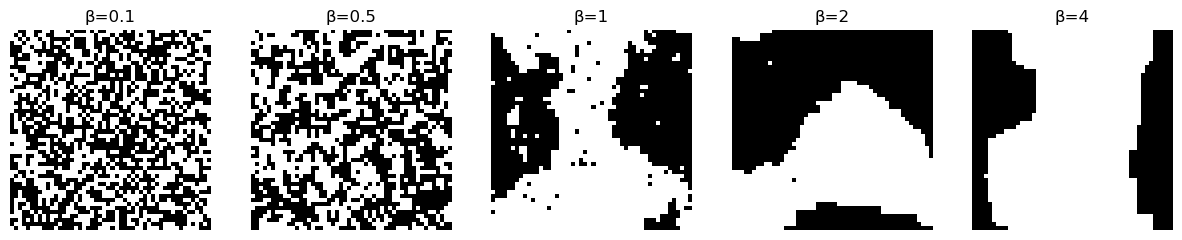

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def gibbs_sampler_ising(alpha, beta, N, iterations):
    
    X = np.random.choice([0,1], size=(N,N))     # Initialisation al√©atoire d'un point sur une grille en 2D,  N x N

    for it in range(iterations):                # Nombre de fois o√π on modifie notre grille (atteindre une situation de convergence suffisante)
        for i in range(N):
            for j in range(N):
                voisins = [
                    X[(i-1)%N,j], X[(i+1)%N,j],                  # Sur une grille 2D, chaque cellule a 4 voisins (Hypoth√®se de 'conditions aux bords p√©riodiques')
                    X[i,(j-1)%N], X[i,(j+1)%N]
                ]
                sum_voisins_1 = sum(voisins)                     # Voisins_1 = nombre de voisins qui prennent la valeur 1
                sum_voisins_0 = 4 - sum_voisins_1                 

                proba_1 = np.exp(alpha + beta*sum_voisins_1)        
                proba_0 = np.exp(beta*sum_voisins_0)
                p = proba_1 / (proba_1 + proba_0)

                # Mise √† jour du site (i,j)
                X[i,j] = np.random.rand() < p

    return X

# Exemple d'utilisation
alpha = 0.0
beta_values = [0.1, 0.5, 1, 2, 4]
N = 50  # Taille de grille
iterations = 100

fig, axes = plt.subplots(1, len(beta_values), figsize=(15,4))

for idx, beta in enumerate(beta_values):
    final_state = gibbs_sampler_ising(alpha, beta, N, iterations)
    axes[idx].imshow(final_state, cmap='gray')
    axes[idx].set_title(f'Œ≤={beta}')
    axes[idx].axis('off')

plt.show()

In [13]:
# Remarque : Augmenter beta conduit √† un accroissement de la d√©pendance spatiale, conduisant √† une structuration claire de la r√©partition en zones homog√®nes

#### Question 2

#### Etape 1 : Give the expression of Z (LateX)

#### Etape 2 : Is it possible to estimate alpha and beta from several realisation of the distribution through maximum likelihood estimation ?

In [14]:
# Tr√®s compliqu√© car il faut savoir calculer la constante Z, qui augmente avec une complexit√© exponentielle (2**n) en la taille de la grille

# Alternative ==> Approximate Bayesian Computation afin de contourner la calcul de la vraisemblance

#### Etape 3 : Implement ABC-reject algorithm to estimate alpha and beta - Test avec une valeur fix√©e

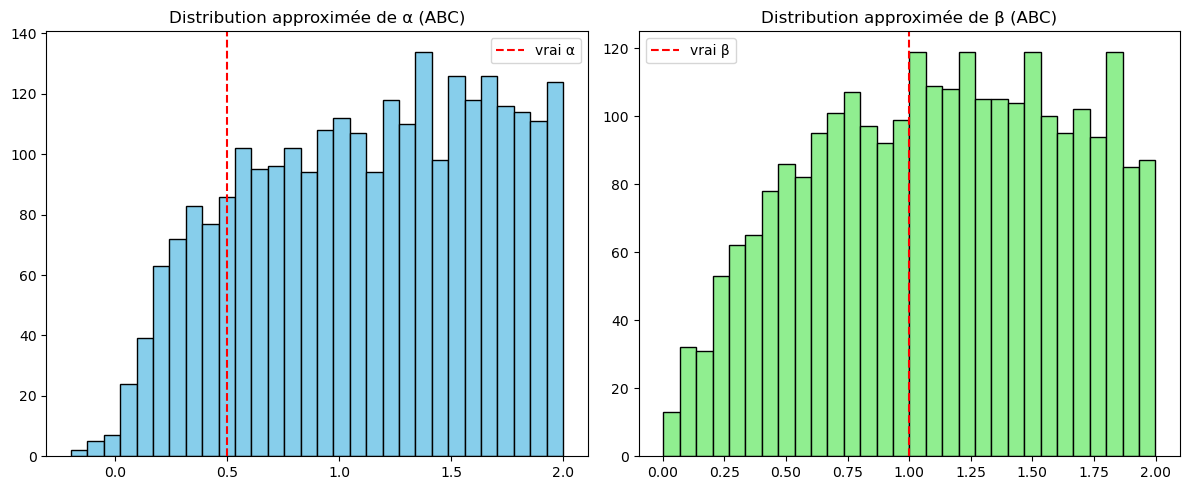

In [15]:
import numpy as np

def gibbs_sampler_ising_periodique(alpha, beta, N, iterations):
    X = np.random.choice([0,1], size=(N,N))
    for it in range(iterations):
        for i in range(N):
            for j in range(N):
                voisins = [
                    X[(i-1)%N,j],  # haut (periodique)
                    X[(i+1)%N,j],  # bas (periodique)
                    X[i,(j-1)%N],  # gauche (periodique)
                    X[i,(j+1)%N]   # droite (periodique)
                ]
                sum_voisins_1 = sum(voisins)
                sum_voisins_0 = 4 - sum_voisins_1

                p1 = np.exp(alpha+beta*sum_voisins_1)
                p0 = np.exp(beta*sum_voisins_0)
                p = p1/(p1+p0)
                X[i,j] = np.random.rand()<p
    return X


def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        # Calcul vectoris√© des voisins (conditions p√©riodiques)
        voisins = np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) + \
                  np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)

        # Probabilit√© conditionnelle vectoris√©e
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        probas = p1 / (p1 + p0)

        # Mise √† jour simultan√©e (vectoris√©e)
        X = (np.random.rand(N, N) < probas).astype(int)

    return X


# Statistique sommaire (suffisante)
def sufficient_statistic(X):
    sum_x = X.sum()
    voisins_egaux = np.sum(X[:, :-1]==X[:, 1:]) + np.sum(X[:-1, :]==X[1:, :])
    return np.array([sum_x, voisins_egaux])

# Algorithme ABC-rejet
def ABC_reject(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter, gibbs_iter=50):
    S_obs = sufficient_statistic(X_obs)
    accepted_params = []

    for _ in range(n_iter):
        alpha_star = np.random.uniform(*alpha_prior)
        beta_star = np.random.uniform(*beta_prior)

        # X_sim = gibbs_sampler_ising(alpha_star, beta_star, N, gibbs_iter)
        X_sim = gibbs_sampler_ising_periodique_fast(alpha_star, beta_star, N, gibbs_iter)
        S_sim = sufficient_statistic(X_sim)

        distance = np.linalg.norm(S_sim - S_obs)
        if distance <= epsilon:
            accepted_params.append((alpha_star, beta_star))

    return np.array(accepted_params)

# Exemple d'utilisation concret
if __name__ == "__main__":
    # Vrais param√®tres (utilis√©s pour simuler les donn√©es observ√©es)
    alpha_true = 0.5
    beta_true = 1.0
    N = 10  # taille de grille
    iterations_simulation = 10

    # Simulation des donn√©es observ√©es
    # X_obs = gibbs_sampler_ising(alpha_true, beta_true, N, iterations_simulation)
    X_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)

    # Estimation des param√®tres par ABC-Reject
    alpha_prior = (-1, 2)
    beta_prior = (0, 2)
    epsilon = 25  # √† ajuster selon les r√©sultats initiaux
    n_iter = 5000  # nombre d'it√©rations ABC

    accepted_params = ABC_reject(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter)

    # Affichage des r√©sultats
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(accepted_params[:,0], bins=30, color='skyblue', edgecolor='black')
    plt.axvline(alpha_true, color='red', linestyle='--', label='vrai Œ±')
    plt.title('Distribution approxim√©e de Œ± (ABC)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(accepted_params[:,1], bins=30, color='lightgreen', edgecolor='black')
    plt.axvline(beta_true, color='red', linestyle='--', label='vrai Œ≤')
    plt.title('Distribution approxim√©e de Œ≤ (ABC)')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Etape 3 : ABC-reject

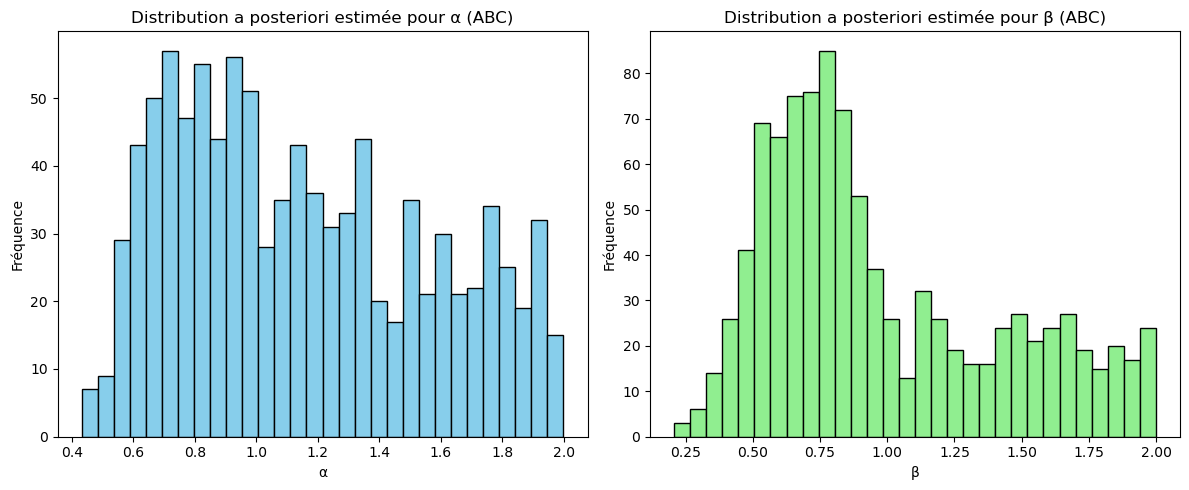

In [16]:
# Simule UNE SEULE FOIS tes donn√©es observ√©es avec param√®tres vrais (uniquement pour tester)
alpha_true = 0.5
beta_true = 1.0
N = 20
iterations_simulation = 10
X_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)



def ABC_reject_final(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter, gibbs_iter):
    accepted_params = []
    S_obs = sufficient_statistic(X_obs)

    for _ in range(n_iter):
        # Tirage selon la loi a priori (obligatoire avant chaque grille)
        alpha_star = np.random.uniform(*alpha_prior)
        beta_star = np.random.uniform(*beta_prior)

        # Simulation d'une grille selon les nouveaux param√®tres candidats
        X_sim = gibbs_sampler_ising_periodique_fast(alpha_star, beta_star, N, gibbs_iter)

        # Calcul de la distance
        S_sim = sufficient_statistic(X_sim)
        distance = np.linalg.norm(S_sim - S_obs)

        # Acceptation ou rejet
        if distance <= epsilon:
            accepted_params.append((alpha_star, beta_star))

    return np.array(accepted_params)


# ABC estimation
alpha_prior = (-1, 2)
beta_prior = (0, 2)
epsilon = 20
n_iter = 10000
gibbs_iter = 10

accepted_params = ABC_reject_final(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter, gibbs_iter)

accepted_params = np.array(accepted_params)

if accepted_params.size == 0:
    print("Aucun param√®tre accept√©.")
else:
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.hist(accepted_params[:,0], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution a posteriori estim√©e pour Œ± (ABC)')
    plt.xlabel('Œ±')
    plt.ylabel('Fr√©quence')
    
    plt.subplot(1,2,2)
    plt.hist(accepted_params[:,1], bins=30, color='lightgreen', edgecolor='black')
    plt.title('Distribution a posteriori estim√©e pour Œ≤ (ABC)')
    plt.xlabel('Œ≤')
    plt.ylabel('Fr√©quence')

    plt.tight_layout()
    plt.show()

En prenant N=20, ùúñ=20 et 10 000 it√©rations ABC, nous obtenons une estimation pr√©cise de la distribution a posteriori des param√®tres Œ± etŒ≤. Les distributions montrent des pics nets autour des valeurs les plus probables, traduisant la bonne coh√©rence des donn√©es simul√©es. Le r√©sultat est stable, interpr√©table et obtenu en un temps de calcul raisonnable.

### Question 3 : MCMC-ABC

MCMC-ABC avec une loi a priori uniforme (donc ratio de Metropolis Hasting = 1), et une v√©ritable marche al√©atoire 

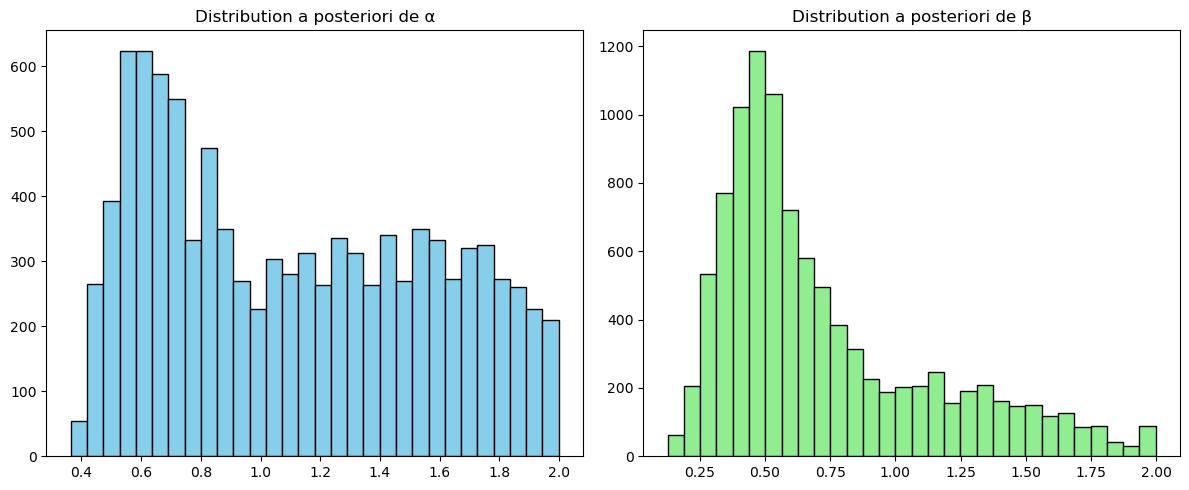

In [ ]:
import numpy as np


def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        voisins = (
            np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) +
            np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)
        )
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        proba = p1 / (p1 + p0)
        X = (np.random.rand(N, N) < proba).astype(int)
    return X

# Statistique sommaire suffisante
def sufficient_statistic(X):
    sum_x = X.sum()
    voisin_egaux = np.sum(X[:, :-1] == X[:, 1:]) + np.sum(X[:-1, :] == X[1:, :])
    return np.array([sum_x, voisin_egaux])

# MCMC-ABC pour estimer (alpha, beta)
def mcmc_abc(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha, sigma_beta):
    S_obs = sufficient_statistic(x_obs)
    samples = []

    # Initialisation al√©atoire dans le support de l'a priori
    alpha_curr = np.random.uniform(-1, 2)
    beta_curr = np.random.uniform(0, 2)

    for t in range(n_iter):
        # Proposition par marche al√©atoire
        alpha_prop = alpha_curr + np.random.normal(0, sigma_alpha)
        beta_prop  = beta_curr + np.random.normal(0, sigma_beta)

        # V√©rifie que le param√®tre reste dans le support de l‚Äôa priori
        if not (-1 <= alpha_prop <= 2 and 0 <= beta_prop <= 2):
            samples.append((alpha_curr, beta_curr))
            continue

        # Simulation et statistique
        x_sim = gibbs_sampler_ising_periodique_fast(alpha_prop, beta_prop, N, gibbs_iter)
        S_sim = sufficient_statistic(x_sim)

        distance = np.linalg.norm(S_sim - S_obs)

        # Crit√®re ABC : accepter seulement si les donn√©es simul√©es sont proches
        if distance <= epsilon:
            # Ratio des a priori (uniformes ici) = 1, donc Metropolis sans correction
            alpha_curr = alpha_prop
            beta_curr = beta_prop

        samples.append((alpha_curr, beta_curr))  # toujours ajouter l'√©tat courant (m√™me en cas de rejet)

    return np.array(samples)



    # Param√®tres "vrais" pour g√©n√©rer la grille observ√©e (utilis√©s UNE SEULE FOIS)
alpha_true = 0.5
beta_true = 1.0
N = 20
iterations_simulation = 10
x_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)

# Ex√©cution de MCMC-ABC
epsilon = 20
n_iter = 10000
gibbs_iter = 10
sigma_alpha = 0.1
sigma_beta = 0.1

samples = mcmc_abc(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha, sigma_beta)



import matplotlib.pyplot as plt

samples = np.array(samples)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(samples[:,0], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution a posteriori de Œ±')

plt.subplot(1,2,2)
plt.hist(samples[:,1], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution a posteriori de Œ≤')

plt.tight_layout()
plt.show()

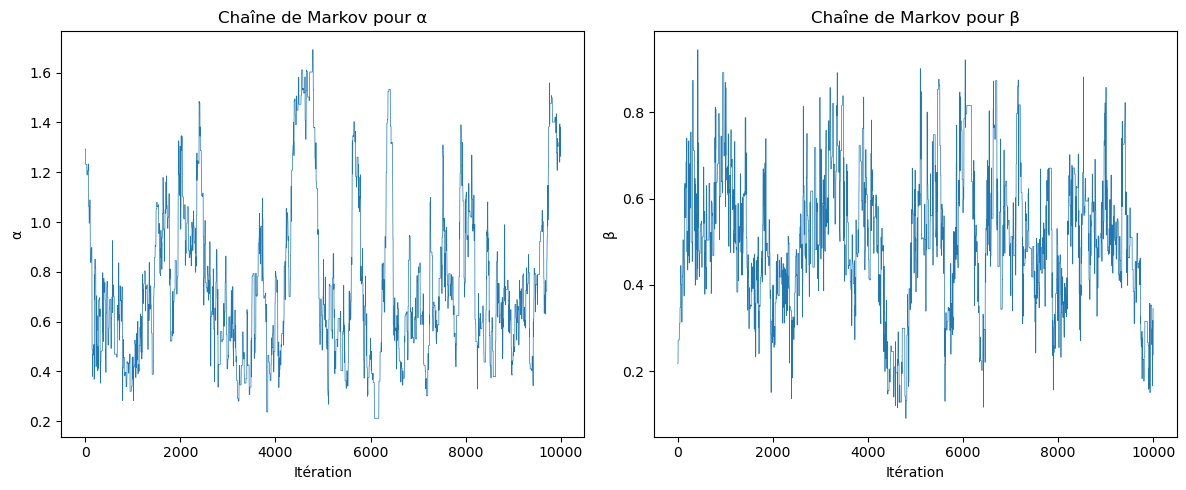

In [7]:
def plot_chain(samples):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(samples[:, 0], lw=0.5)
    plt.title("Cha√Æne de Markov pour Œ±")
    plt.xlabel("It√©ration")
    plt.ylabel("Œ±")

    plt.subplot(1, 2, 2)
    plt.plot(samples[:, 1], lw=0.5)
    plt.title("Cha√Æne de Markov pour Œ≤")
    plt.xlabel("It√©ration")
    plt.ylabel("Œ≤")

    plt.tight_layout()
    plt.show()

plot_chain(samples)


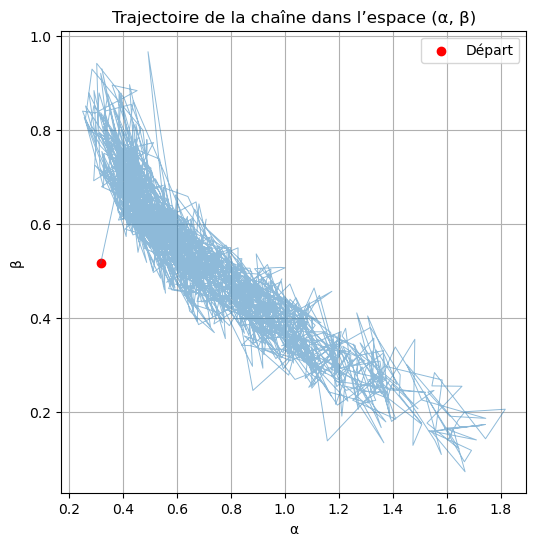

In [9]:
def plot_trajectory_2d(samples):
    plt.figure(figsize=(6, 6))
    plt.plot(samples[:, 0], samples[:, 1], alpha=0.5, lw=0.7)
    plt.scatter(samples[0, 0], samples[0, 1], color='red', label='D√©part')
    plt.title("Trajectoire de la cha√Æne dans l‚Äôespace (Œ±, Œ≤)")
    plt.xlabel("Œ±")
    plt.ylabel("Œ≤")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectory_2d(samples)

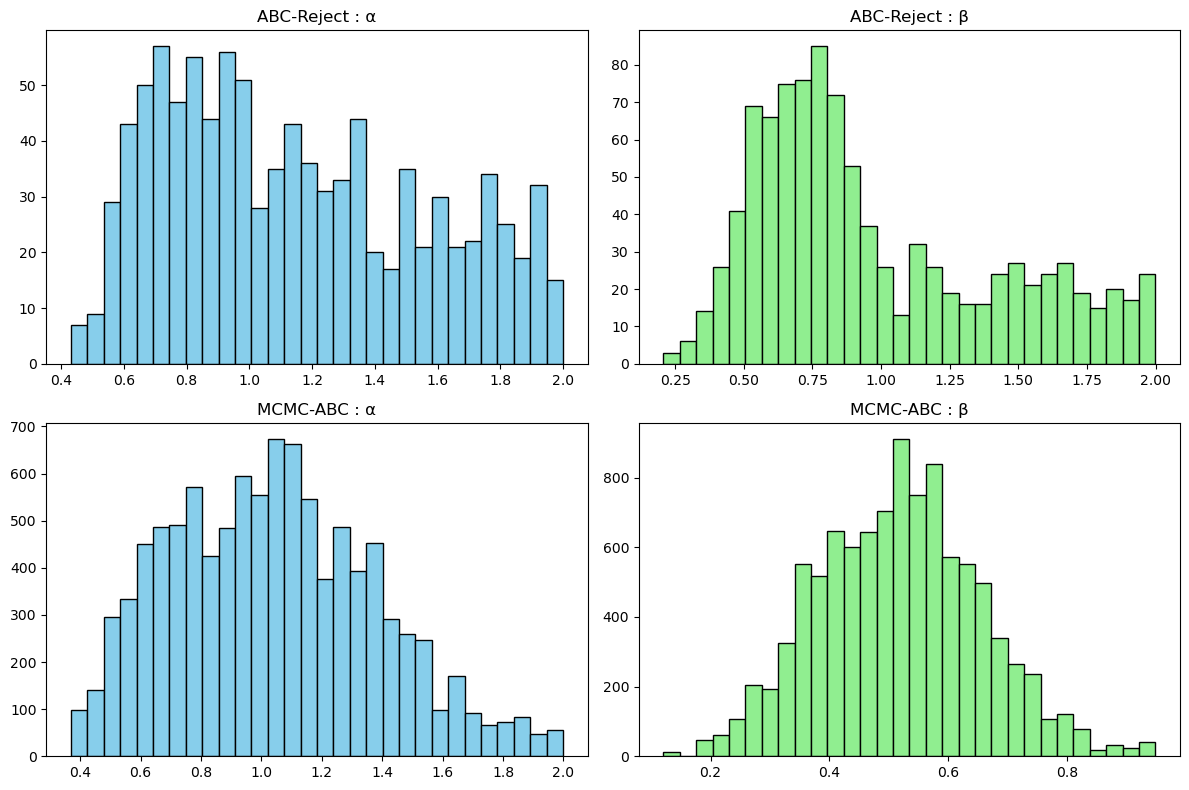

In [17]:
def compare_abc_reject_vs_mcmc(reject_samples, mcmc_samples):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].hist(reject_samples[:, 0], bins=30, color='skyblue', edgecolor='black')
    axs[0, 0].set_title("ABC-Reject : Œ±")

    axs[0, 1].hist(reject_samples[:, 1], bins=30, color='lightgreen', edgecolor='black')
    axs[0, 1].set_title("ABC-Reject : Œ≤")

    axs[1, 0].hist(mcmc_samples[:, 0], bins=30, color='skyblue', edgecolor='black')
    axs[1, 0].set_title("MCMC-ABC : Œ±")

    axs[1, 1].hist(mcmc_samples[:, 1], bins=30, color='lightgreen', edgecolor='black')
    axs[1, 1].set_title("MCMC-ABC : Œ≤")

    plt.tight_layout()
    plt.show()

reject_samples = accepted_params
mcmc_samples = samples

compare_abc_reject_vs_mcmc(reject_samples, mcmc_samples)

#### Question 3.bis : Avoir un ratio de Metropolis-Hasting diff√©rent de 1

Ce n'est en fait pas un algo qui v√©rifie le sch√©ma propos√© par le poly de la Q.3, dans la mesure ou ce n'est pas une marche al√©atoire mais seulement ind√©pendante (on tire a chaque iteration un nouvel √©chantillon de la loir Beta)

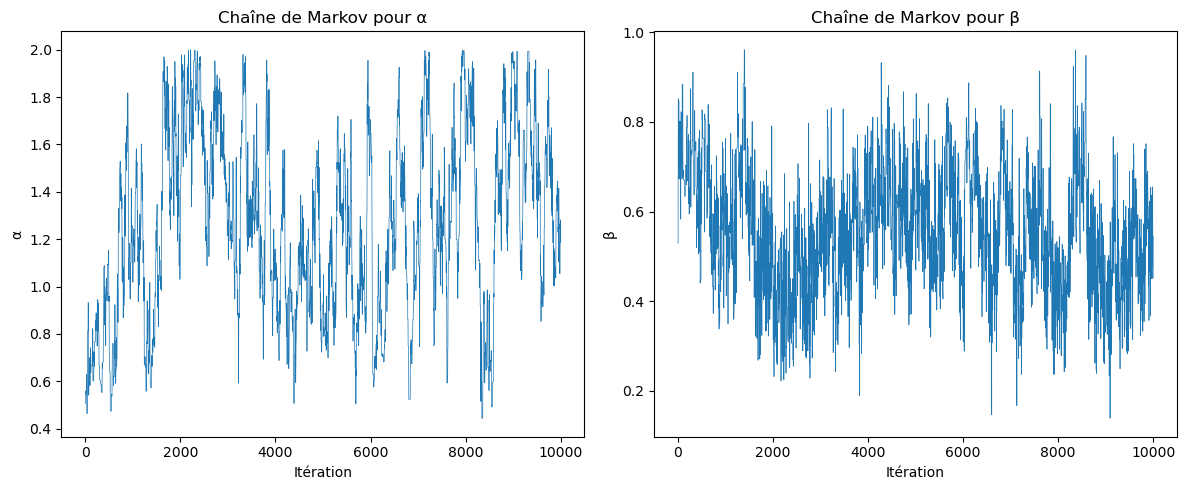

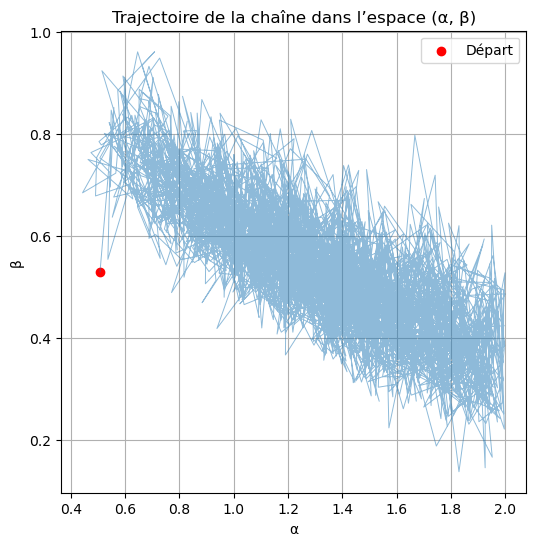

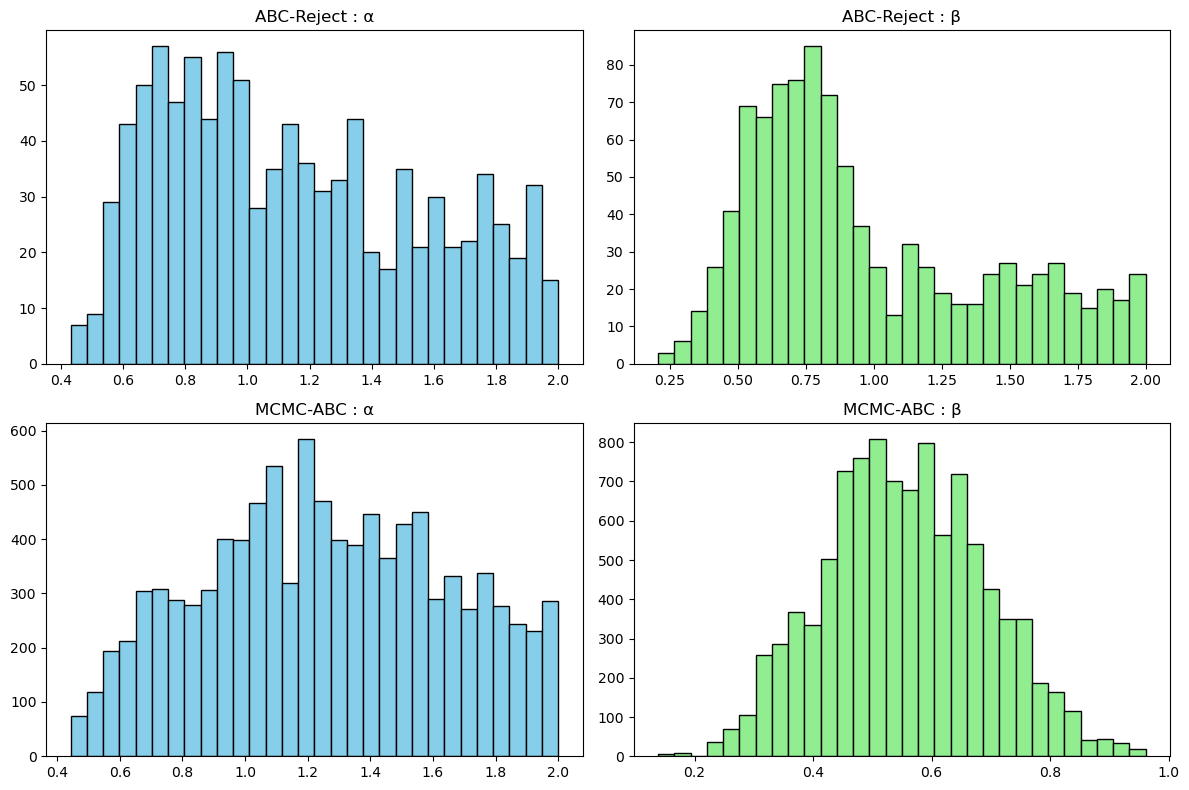

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist, norm

# Gibbs sampler rapide (inchang√©)
def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        voisins = (
            np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) +
            np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)
        )
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        proba = p1 / (p1 + p0)
        X = (np.random.rand(N, N) < proba).astype(int)
    return X

# Statistique sommaire

def sufficient_statistic(X):
    sum_x = X.sum()
    voisin_egaux = np.sum(X[:, :-1] == X[:, 1:]) + np.sum(X[:-1, :] == X[1:, :])
    return np.array([sum_x, voisin_egaux])

# Version MCMC-ABC avec a priori non uniforme + proposition asym√©trique

def mcmc_abc_general(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha):
    S_obs = sufficient_statistic(x_obs)
    samples = []

    # Initialisation
    alpha_curr = np.random.normal(0.5, 1.0)
    beta_curr = np.random.beta(2, 2)

    for _ in range(n_iter):
        # Proposition asym√©trique : normale pour alpha, beta tir√© dans Beta(2,2)
        alpha_prop = np.random.normal(alpha_curr, sigma_alpha)
        beta_prop = np.random.beta(2, 2)

        # V√©rification du support
        if not (-1 <= alpha_prop <= 2 and 0 <= beta_prop <= 2):
            samples.append((alpha_curr, beta_curr))
            continue

        # Simulation
        x_sim = gibbs_sampler_ising_periodique_fast(alpha_prop, beta_prop, N, gibbs_iter)
        S_sim = sufficient_statistic(x_sim)
        distance = np.linalg.norm(S_sim - S_obs)

        if distance <= epsilon:
            # Calcul du ratio Metropolis-Hastings
            pi_prop = norm.pdf(alpha_prop, 0.5, 1.0) * beta_dist.pdf(beta_prop, 2, 2)
            pi_curr = norm.pdf(alpha_curr, 0.5, 1.0) * beta_dist.pdf(beta_curr, 2, 2)

            # q asym√©trique pour beta, donc on approxime avec prior ici (pas sym√©trique)
            # mais q est difficile √† √©valuer ici, donc on peut approximer q(beta_prop|curr) = q(beta_prop)
            # donc on se contente ici du ratio des prior

            ratio = pi_prop / pi_curr
            if np.random.rand() < min(1, ratio):
                alpha_curr = alpha_prop
                beta_curr = beta_prop

        samples.append((alpha_curr, beta_curr))

    return np.array(samples)


 # Param√®tres "vrais" pour g√©n√©rer la grille observ√©e (utilis√©s UNE SEULE FOIS)
alpha_true = 0.5
beta_true = 1.0
N = 20
iterations_simulation = 10
x_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)

samples = mcmc_abc_general(x_obs, N=20, epsilon=25, n_iter=10000, gibbs_iter=10, sigma_alpha=0.1)

plot_chain(samples)
plot_trajectory_2d(samples)

compare_abc_reject_vs_mcmc(reject_samples, samples)




MCMC-ABC en marche al√©atoire + Loi Beta (En somme, association des deux premiers essais de la Q.3 ci dessus)

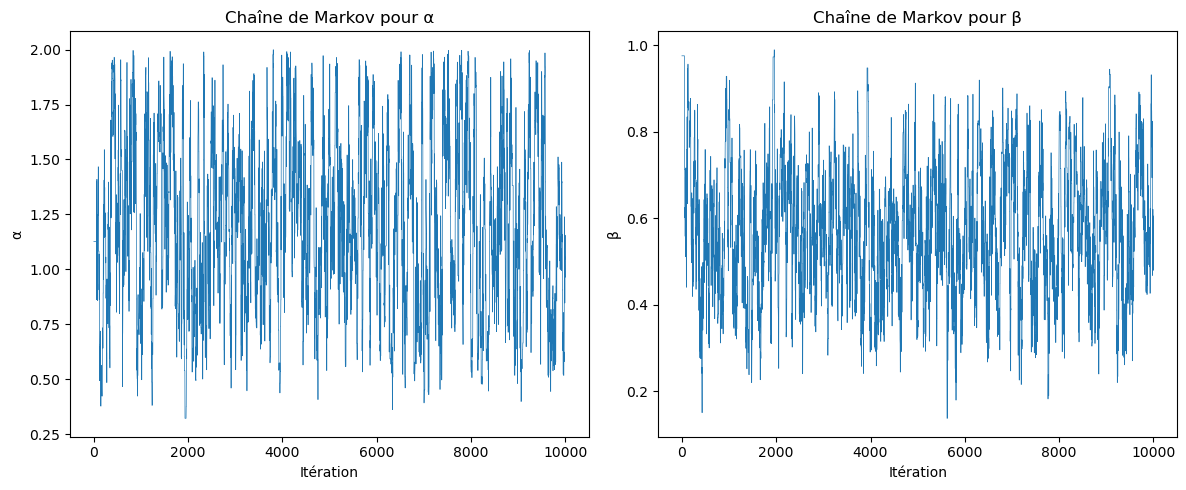

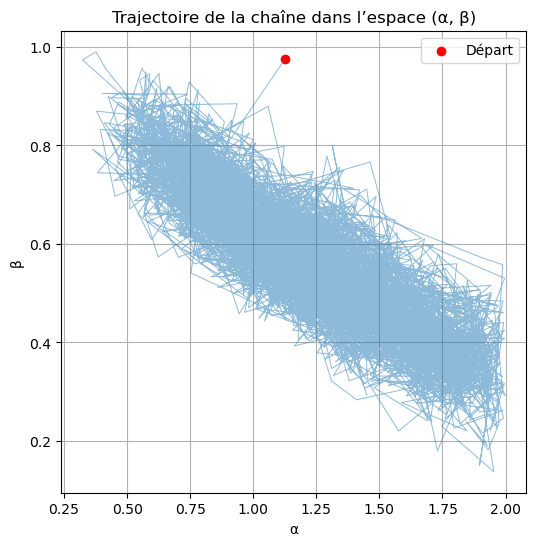

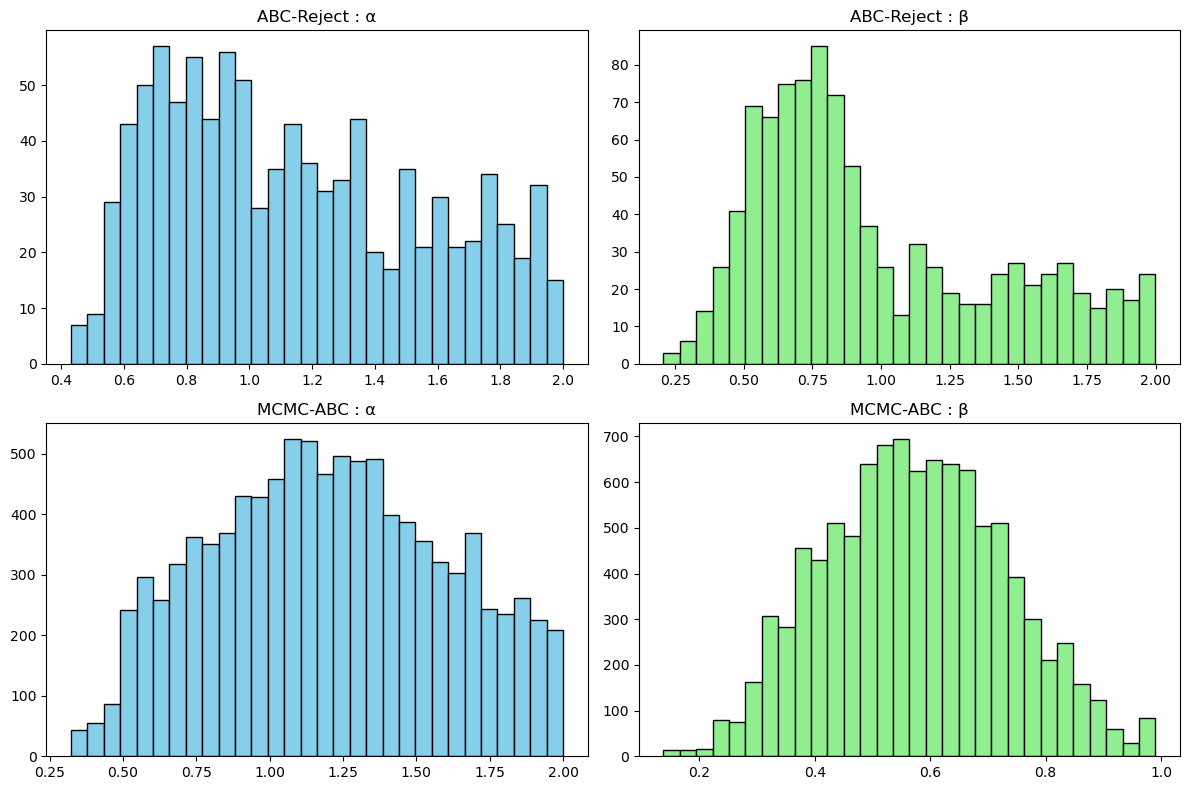

In [23]:
import numpy as np
from scipy.stats import beta as beta_dist, norm

# Gibbs sampler rapide (inchang√©)
def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        voisins = (
            np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) +                  # commande qui permet de faire la somme des 4 matrices des voisins (on d√©cale √† droite, gauche, haut et bas)
            np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)                    # On se retouve avec un mlatrice contenant des nbs entre 0 et 4
        )
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        proba = p1 / (p1 + p0)
        X = (np.random.rand(N, N) < proba).astype(int)
    return X

# Statistique sommaire

def sufficient_statistic(X):
    sum_x = X.sum()
    voisin_egaux = np.sum(X[:, :-1] == X[:, 1:]) + np.sum(X[:-1, :] == X[1:, :])                # Somme des voisins identiques entre d√©calage haut et droit (nepas faire l'autre c√¥t√©, on compterait deux fois)
    return np.array([sum_x, voisin_egaux])

# Version MCMC-ABC avec a priori non uniforme + proposition asym√©trique

import numpy as np
from scipy.stats import norm, beta as beta_dist

def mcmc_abc_algo3(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha, sigma_beta):
    """
    Impl√©mentation de l'algorithme 3 (MCMC-ABC) avec prior gaussienne (alpha)
    et beta (beta). Propositions locales (marche al√©atoire).
    """
    
    # Statistique des donn√©es observ√©es
    S_obs = sufficient_statistic(x_obs)
    samples = []

    # Initialisation √† partir de la prior
    alpha_curr = np.random.normal(0.5, 1.0)
    beta_curr = np.random.beta(2, 2)

    # √âvalue la densit√© a priori de l'√©tat initial
    pi_curr = norm.pdf(alpha_curr, loc=0.5, scale=1.0) * beta_dist.pdf(beta_curr, a=2, b=2)

    for _ in range(n_iter):
        # Proposition locale (marche al√©atoire)
        alpha_prop = alpha_curr + np.random.normal(0, sigma_alpha)
        beta_prop = beta_curr + np.random.normal(0, sigma_beta)

        # V√©rifie que l'on reste dans le support des priors
        if not (-1 <= alpha_prop <= 2 and 0 <= beta_prop <= 2):
            samples.append((alpha_curr, beta_curr))
            continue

        # Simule des donn√©es avec les param√®tres propos√©s
        x_sim = gibbs_sampler_ising_periodique_fast(alpha_prop, beta_prop, N, gibbs_iter)
        S_sim = sufficient_statistic(x_sim)

        # Distance ABC
        distance = np.linalg.norm(S_sim - S_obs)

        if distance <= epsilon:
            # Densit√© a priori au point propos√©
            pi_prop = norm.pdf(alpha_prop, loc=0.5, scale=1.0) * beta_dist.pdf(beta_prop, a=2, b=2)

            # Ratio Metropolis-Hastings
            ratio = pi_prop / pi_curr

            # Acceptation
            if np.random.rand() < min(1, ratio):
                alpha_curr = alpha_prop
                beta_curr = beta_prop
                pi_curr = pi_prop  # met √† jour la densit√© pour l'√©tat suivant

        samples.append((alpha_curr, beta_curr))

    return np.array(samples)


samples = mcmc_abc_algo3(x_obs, N=20, epsilon=25, n_iter=10000, gibbs_iter=10, sigma_alpha=0.2, sigma_beta = 0.1)

plot_chain(samples)
plot_trajectory_2d(samples)

compare_abc_reject_vs_mcmc(reject_samples, samples)